In [118]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob

import tensorflow as tf
import pickle
import os
import glob
import random
import sys
import datetime
import wispy
import wispy.resnet
import wispy.logger
import wispy.utils
import wispy.callbacks
import wispy.model_utils
from tomlkit import parse
from tensorflow.keras.utils import get_custom_objects
import pugna.activations

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [119]:
from wispy import lalutils, rotations 

In [120]:
sys.path.append("../")

In [121]:
import fit

In [122]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})
get_custom_objects().update({'ScaleLayer': wispy.mscalev3.ScaleLayer})

In [123]:
%matplotlib inline

# load models

In [124]:
models = {}

In [125]:
!pwd

/home/sebastian.khan/git/stk/ml/waveforms/aug2021/test-5d-1e6


In [126]:
!ls

alpha				      gamma
amp_21				      phi_21
amp_22				      phi_22
amps				      plot-prediction-waveform.ipynb
beta				      pre_processing
compute_preprocessing.toml	      run-gen-training.sh
data_generation_coprec_training.toml  run-preproc.sh
data_generation_coprec_val.toml       training_data
data_logs			      validation_data


In [127]:
glob.glob("amps/009/checkpoint/*")[-1]

'amps/009/checkpoint/cp-02080.ckpt'

In [128]:
glob.glob("alpha/009/checkpoint/*")[-1]

'alpha/009/checkpoint/cp-02870.ckpt'

In [129]:
glob.glob("beta/009/checkpoint/*")[-1]

'beta/009/checkpoint/cp-02810.ckpt'

In [130]:
glob.glob("gamma/009/checkpoint/*")[-1]

'gamma/009/checkpoint/cp-02850.ckpt'

In [131]:
glob.glob("phi_22/009/checkpoint/*")[-1]

'phi_22/009/checkpoint/cp-04850.ckpt'

In [132]:
glob.glob("phi_21/009/checkpoint/*")[-1]

'phi_21/009/checkpoint/cp-03800.ckpt'

In [134]:
models['amps'] = tf.keras.models.load_model('amps/009/checkpoint/cp-02080.ckpt')
models['alpha'] = tf.keras.models.load_model('alpha/009/checkpoint/cp-02870.ckpt')
models['beta'] = tf.keras.models.load_model('beta/009/checkpoint/cp-02810.ckpt')
models['gamma'] = tf.keras.models.load_model('gamma/009/checkpoint/cp-02850.ckpt')
models['phi_22'] = tf.keras.models.load_model('phi_22/009/checkpoint/cp-04850.ckpt')
models['phi_21'] = tf.keras.models.load_model('phi_21/009/checkpoint/cp-03800.ckpt')

In [135]:
filename = './training_data/times.npy'
times = np.load(filename)

pkl_filename = './pre_processing/times_scaler.pkl'
with open(pkl_filename, 'rb') as file:
    times_scaler = pickle.load(file)

times_scaled = times_scaler.transform(times[:, np.newaxis])

In [136]:
preprocparams = dict(np.load('./pre_processing/preprocessing_params.npz'))

In [137]:
preprocparams

{'alpha': array(33.28964202),
 'amp_21': array(0.09379515),
 'amp_22': array(0.39594291),
 'beta': array(1.94974453),
 'gamma': array(31.71845662),
 'phi_21': array(100.00407535),
 'phi_22': array(163.71775628)}

In [138]:
# coords_train = np.load("./training_data/coords.npy").T
coords_train = np.load("./validation_data/coords.npy").T

In [139]:
def get_input_for_ann(times, coords):
    return np.column_stack((times[:, 0], (coords*np.ones(times.shape))))

In [140]:
get_input_for_ann(times_scaled, coords_train[0])

array([[-1.00000000e+00,  3.68486232e+00,  1.37118096e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.99178982e-01,  3.68486232e+00,  1.37118096e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-9.98357964e-01,  3.68486232e+00,  1.37118096e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-1.64203612e-03,  3.68486232e+00,  1.37118096e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.21018062e-04,  3.68486232e+00,  1.37118096e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.77555756e-17,  3.68486232e+00,  1.37118096e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [141]:
amp22, amp21 = models['amps'].predict(get_input_for_ann(times_scaled, coords_train[0])).T

In [142]:
amp22.shape

(1219,)

In [143]:
def predict_model(times_scaled, coords):
    
    X = get_input_for_ann(times_scaled, coords)
    
    amp22, amp21 = models['amps'].predict(X).T
    amp22 = amp22*preprocparams['amp_22']
    amp21 = amp21*preprocparams['amp_21']
    alpha = models['alpha'].predict(X)[:,0]*preprocparams['alpha']
    beta = models['beta'].predict(X)[:,0]*preprocparams['beta']
    gamma = models['gamma'].predict(X)[:,0]*preprocparams['gamma']
    
    phi_22 = models['phi_22'].predict(X)[:,0]*preprocparams['phi_22']
    phi_21 = models['phi_21'].predict(X)[:,0]*preprocparams['phi_21']
#     phi_22, phi_21 = models['phis'].predict(X).T
#     phi_22 = phi_22*preprocparams['phi_22']
#     phi_21 = phi_21*preprocparams['phi_21']
    
    y22_complex = amp22 * np.exp(1.j*phi_22) 
    y21_complex = amp21 * np.exp(1.j*phi_21)
    
    plt.figure()
    plt.plot(times_scaled, np.real(y22_complex))
    plt.plot(times_scaled, np.real(y21_complex))
    
    
#     y22_complex = data['amp_22'][67] * np.exp(1.j*data['phi_22'][67]) 
#     y21_complex = data['amp_21'][67] * np.exp(1.j*data['phi_21'][67])
    
#     y22_complex = amp22 * np.exp(1.j*data['phi_22'][67]) 
#     y21_complex = data['amp_21'][67] * np.exp(1.j*data['phi_21'][67])

#     y22_complex = data['amp_22'][67] * np.exp(1.j*phi_22) 
#     y21_complex = data['amp_21'][67] * np.exp(1.j*data['phi_21'][67])

    
    
    hlms_ann = {}
    hlms_ann[(2,2)] = y22_complex
    hlms_ann[(2,1)] = y21_complex
    hlms_ann[(2,0)] = np.zeros(len(y22_complex))*1.j
    hlms_ann[(2,-1)] = y21_complex.conj().copy()
    hlms_ann[(2,-2)] = y22_complex.conj().copy()
    
    wr_ann = rotations.WaveformRotations(
        times=times,
        hlms=hlms_ann,
        frame='coprec',
        alpha=alpha,
        beta=beta,
        gamma=gamma
    ) 
    
    m1, m2 = phenom.m1_m2_M_q(100, coords[0])
    f_ref = 10.
    phiRef = 0.
    s1x, s1y, s1z = data_generation_coprec.polar_to_cart(coords[1], coords[2], coords[3])
    s2x, s2y, s2z = data_generation_coprec.polar_to_cart(coords[4], coords[5], coords[6])
    
    thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
        mass1=m1, mass2=m2, f_ref=f_ref, inc=0, phiref=phiRef,
        spin1x=s1x, spin1y=s1y, spin1z=s1z,
        spin2x=s2x, spin2y=s2y, spin2z=s2z)
    print(thetaJN, alpha0, phi_aligned)
    
    wr_ann.set_alpha0_thetaJN_phi0(alpha0, thetaJN, phi_aligned)
    
    return wr_ann

In [144]:
import data_generation_coprec

In [145]:
data_generation_coprec.polar_to_cart(coords_train[0,1],coords_train[0,2],coords_train[0,3])

(0.12187922494166531, 0.060843981169250244, 0.01564726061621768)

In [146]:
import phenom

In [147]:
phenom.m1_m2_M_q(100, coords_train[0,0])

(78.65465554071127, 21.34534445928873)

In [148]:
coords_train[0]

array([3.68486232, 0.1371181 , 1.45643198, 0.4630197 , 0.        ,
       0.        , 0.        ])

In [149]:
coords_train[:,1].argmax()

754

In [150]:
coords_train

array([[3.68486232, 0.1371181 , 1.45643198, ..., 0.        , 0.        ,
        0.        ],
       [2.80958318, 0.13826517, 1.63791869, ..., 0.        , 0.        ,
        0.        ],
       [3.48150402, 0.86186228, 2.13103554, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.0952098 , 0.2855395 , 1.79949427, ..., 0.        , 0.        ,
        0.        ],
       [1.97063034, 0.36009027, 1.71913237, ..., 0.        , 0.        ,
        0.        ],
       [2.68751174, 0.45500468, 1.41835651, ..., 0.        , 0.        ,
        0.        ]])

In [151]:
# np.where((coords_train[:,1] > 0.9) & (coords_train[:,0] > 3.4) & (coords_train[:,2] > 1.4) & (coords_train[:,2] > 2.3))
np.where((coords_train[:,1] > 0.6) & (coords_train[:,1] < 0.8) & (coords_train[:,0] > 3.4) & (coords_train[:,2] > 1.4) & (coords_train[:,2] < 2.3))

(array([  6, 200, 287, 288, 304, 333, 360, 492, 654, 658, 748, 790, 805,
        985]),)

In [152]:
coords_train[67]

array([3.51739444, 0.59598794, 2.13786977, 1.27361395, 0.        ,
       0.        , 0.        ])

In [315]:
# index=-3
# index=coords_train[:,1].argmax()
# index=coords_train[:,0].argmax()
# index=coords_train[:,0].argmin()
# index=coords_train[:,2].argmax()
# index=12
# index=44
# index=67
index = 288

In [316]:
coords_train[index]

array([3.84839796, 0.6465027 , 1.82053869, 0.39993194, 0.        ,
       0.        , 0.        ])

0.5624048749211314 1.2246467991473532e-16 -0.3999319428422626


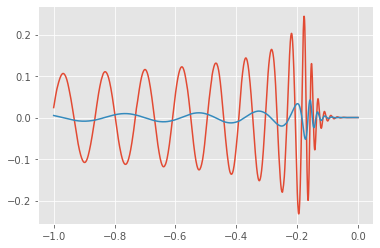

In [317]:
wr_ann = predict_model(times_scaled, coords_train[index])

In [318]:
wr_ann

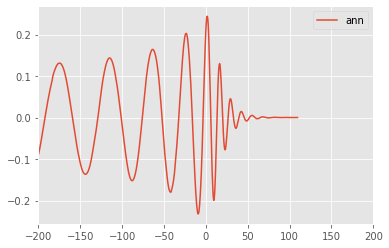

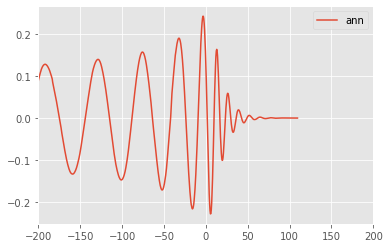

In [319]:
plt.figure()
plt.plot(times, wr_ann.hlms[(2,2)].real, label='ann')
# plt.xlim(-0.2,0.1)
plt.xlim(-200, 200)
plt.legend()

plt.figure()
plt.plot(times, wr_ann.hlms[(2,2)].imag, label='ann')
# plt.xlim(-0.2,0.1)
plt.xlim(-200, 200)
plt.legend()

In [320]:
def plot_modes(wr):
    plt.figure()
    plt.plot(wr.times, np.abs(wr.hlms[(2,2)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,1)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,0)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,-1)]))
    plt.plot(wr.times, np.abs(wr.hlms[(2,-2)]))
    plt.title(wr.frame)
    plt.show()
    plt.close()

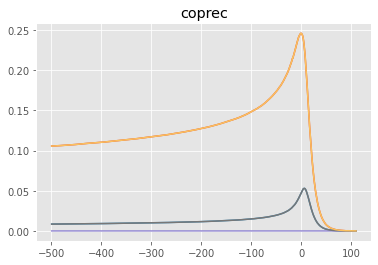

In [321]:
plot_modes(wr_ann)

In [322]:
wr_ann.from_coprecessing_frame_to_inertial_frame()

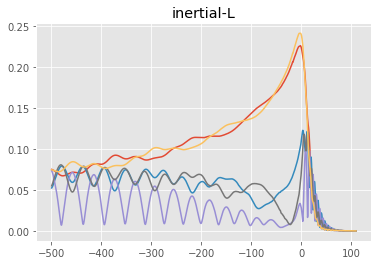

In [323]:
plot_modes(wr_ann)

# load training data

In [324]:
# data = {}
# data['amp_22'] = np.load('./training_data/amp_22.npy')
# data['amp_21'] = np.load('./training_data/amp_21.npy')
# data['phi_22'] = np.load('./training_data/phi_22.npy')
# data['phi_21'] = np.load('./training_data/phi_21.npy')
# data['alpha'] = np.load('./training_data/alpha.npy')
# data['beta'] = np.load('./training_data/beta.npy')
# data['gamma'] = np.load('./training_data/gamma.npy')

data = {}
data['amp_22'] = np.load('./validation_data/amp_22.npy')
data['amp_21'] = np.load('./validation_data/amp_21.npy')
data['phi_22'] = np.load('./validation_data/phi_22.npy')
data['phi_21'] = np.load('./validation_data/phi_21.npy')
data['alpha'] = np.load('./validation_data/alpha.npy')
data['beta'] = np.load('./validation_data/beta.npy')
data['gamma'] = np.load('./validation_data/gamma.npy')

In [325]:
def wr_from_data(coords, i):
    y22_complex = data['amp_22'][i] * np.exp(1.j*data['phi_22'][i]) 
    y21_complex = data['amp_21'][i] * np.exp(1.j*data['phi_21'][i])
    
    plt.figure()
    plt.plot(times_scaled, np.real(y22_complex))
    plt.plot(times_scaled, np.real(y21_complex))
    
    
    hlms = {}
    hlms[(2,2)] = y22_complex
    hlms[(2,1)] = y21_complex
    hlms[(2,0)] = np.zeros(len(y22_complex))*1.j
    hlms[(2,-1)] = y21_complex.conj().copy()
    hlms[(2,-2)] = y22_complex.conj().copy()
    
    wr = rotations.WaveformRotations(
        times=times,
        hlms=hlms,
        frame='coprec',
        alpha=data['alpha'][i],
        beta=data['beta'][i],
        gamma=data['gamma'][i]
    ) 
    
    m1, m2 = phenom.m1_m2_M_q(100, coords[0])
    f_ref = 10.
    phiRef = 0.
    s1x, s1y, s1z = data_generation_coprec.polar_to_cart(coords[1], coords[2], coords[3])
    s2x, s2y, s2z = data_generation_coprec.polar_to_cart(coords[4], coords[5], coords[6])
    
    thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
        mass1=m1, mass2=m2, f_ref=f_ref, inc=0, phiref=phiRef,
        spin1x=s1x, spin1y=s1y, spin1z=s1z,
        spin2x=s2x, spin2y=s2y, spin2z=s2z)
    print(thetaJN, alpha0, phi_aligned)
    
    wr.set_alpha0_thetaJN_phi0(alpha0, thetaJN, phi_aligned)
    
    return wr

0.5624048749211314 1.2246467991473532e-16 -0.3999319428422626


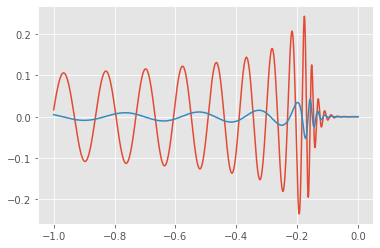

In [326]:
wr_data = wr_from_data(coords_train[index], index)

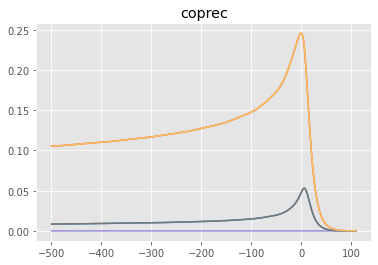

In [327]:
plot_modes(wr_data)

In [328]:
wr_data.from_coprecessing_frame_to_inertial_frame()

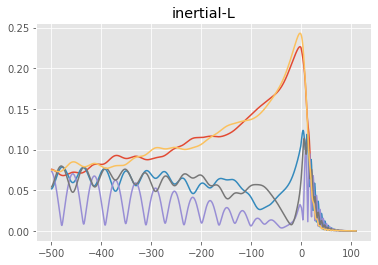

In [329]:
plot_modes(wr_data)

In [330]:
# wr_data.from_coprecessing_frame_to_inertial_frame()
# wr_ann.from_coprecessing_frame_to_inertial_frame()

In [331]:
# wr_data.from_inertial_frame_to_coprecessing_frame()
# wr_ann.from_inertial_frame_to_coprecessing_frame()

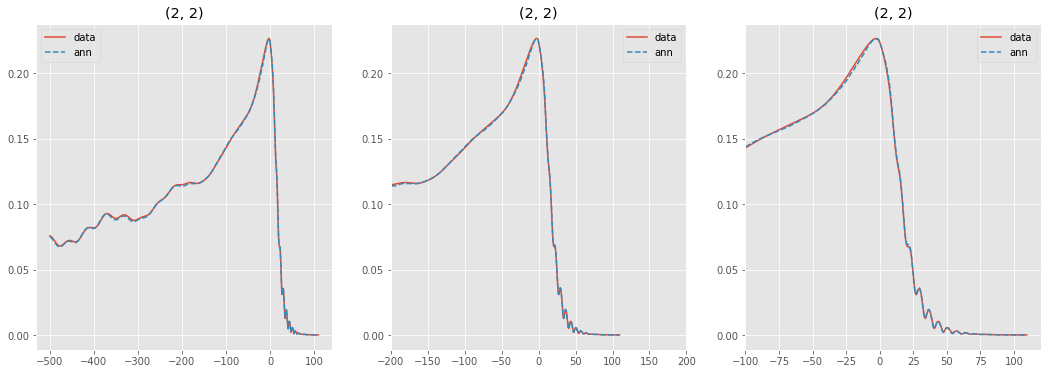

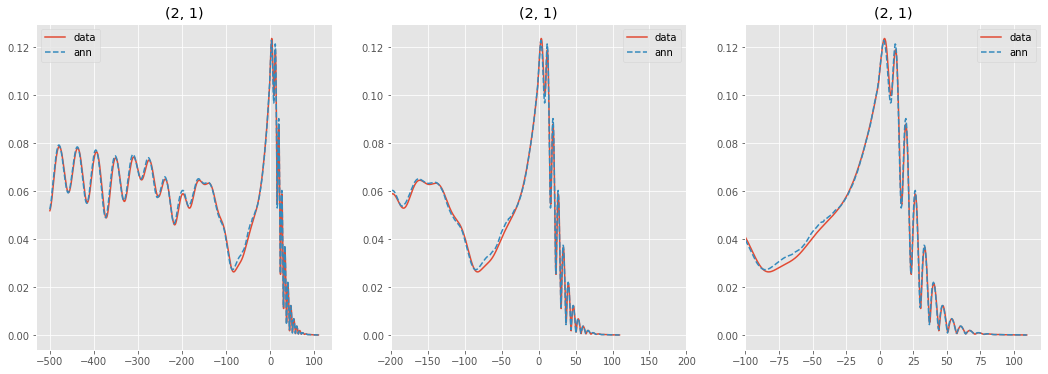

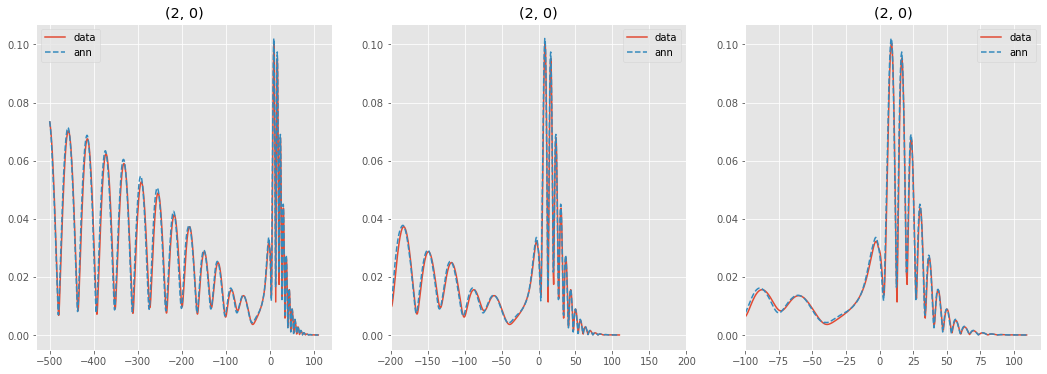

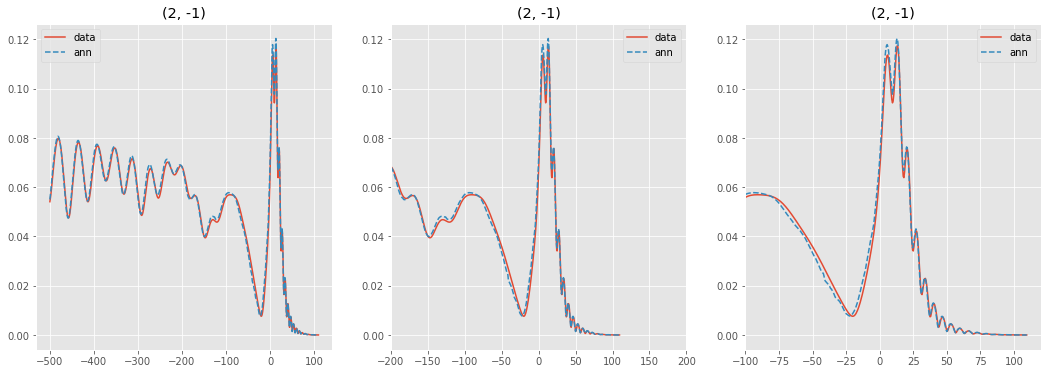

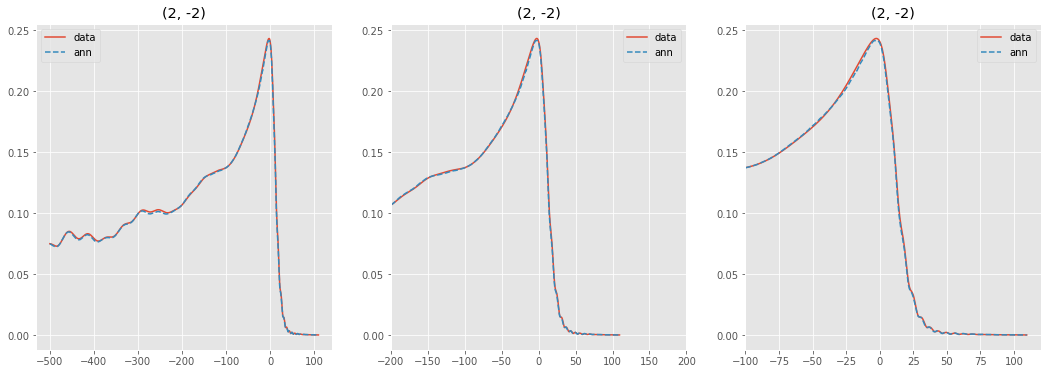

In [332]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()

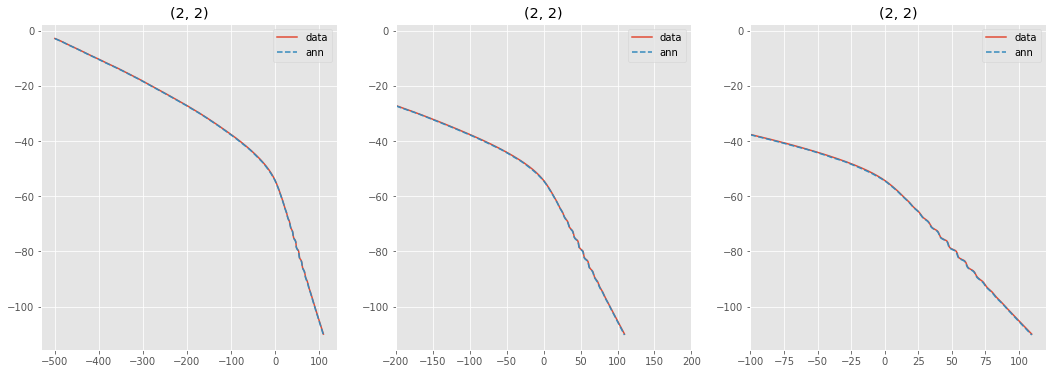

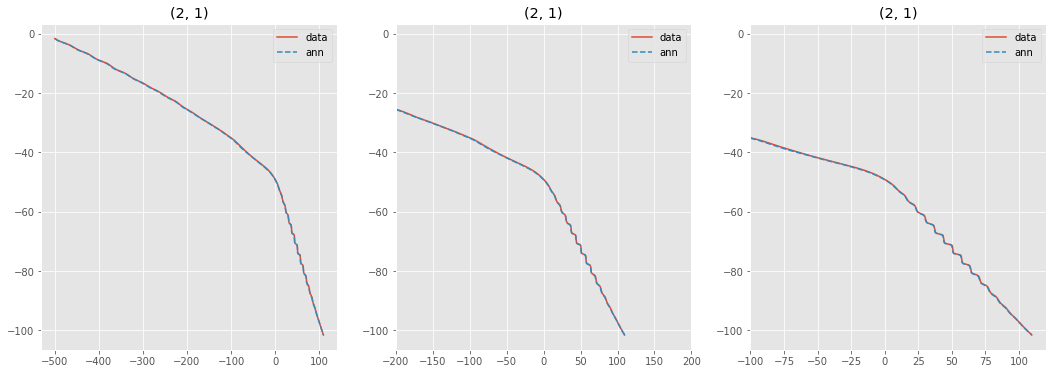

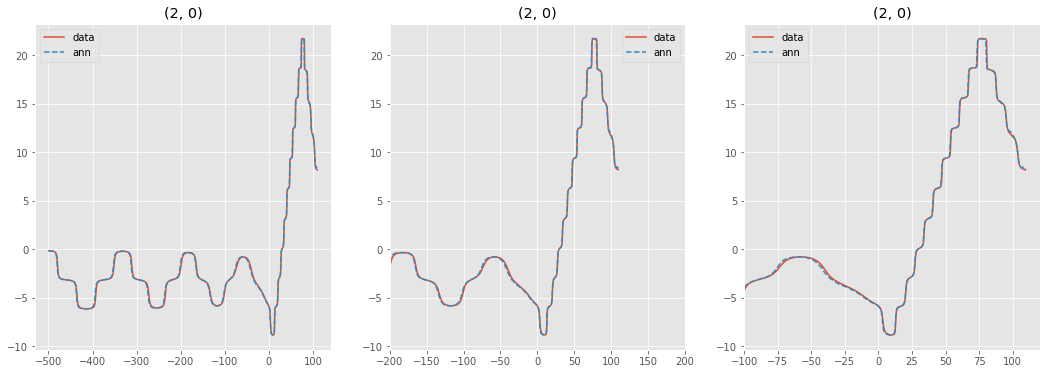

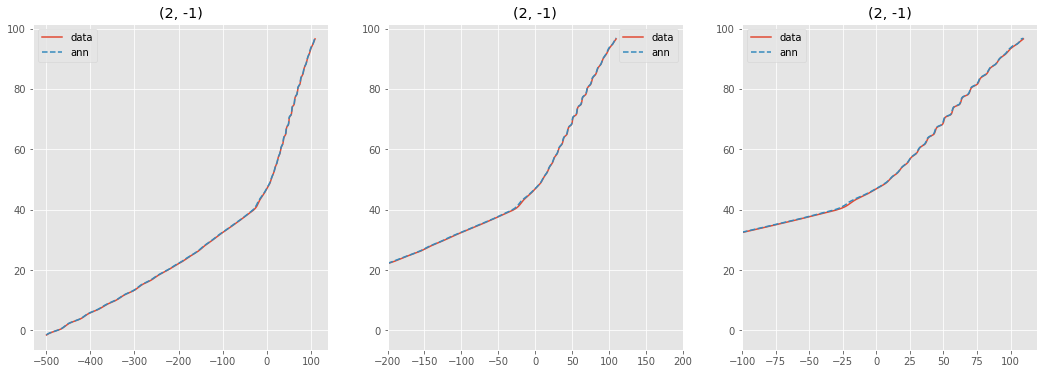

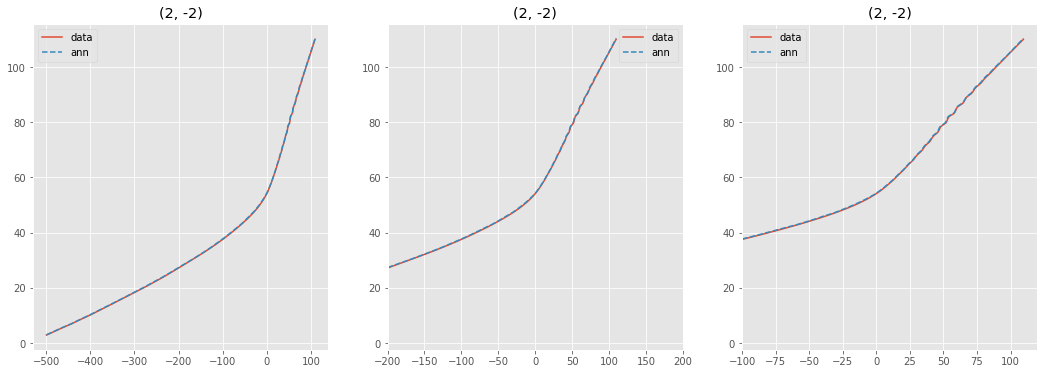

In [333]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.unwrap(np.angle(wr_data.hlms[key])), label='data' )
    plt.plot(times, np.unwrap(np.angle(wr_ann.hlms[key])), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.unwrap(np.angle(wr_data.hlms[key])), label='data' )
    plt.plot(times, np.unwrap(np.angle(wr_ann.hlms[key])), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.unwrap(np.angle(wr_data.hlms[key])), label='data' )
    plt.plot(times, np.unwrap(np.angle(wr_ann.hlms[key])), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()

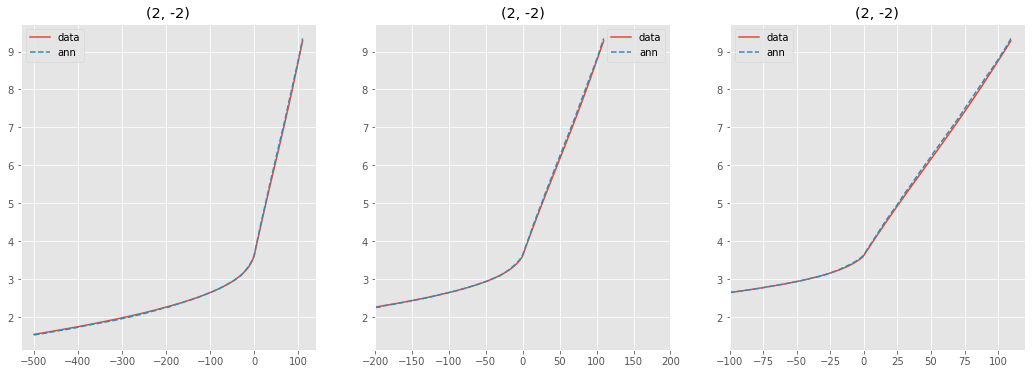

In [334]:

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(times, np.abs(wr_data.alpha), label='data' )
plt.plot(times, np.abs(wr_ann.alpha), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
plt.title(key)
plt.legend()

plt.subplot(1,3,2)
plt.plot(times, np.abs(wr_data.alpha), label='data' )
plt.plot(times, np.abs(wr_ann.alpha), label='ann',ls='--')
plt.xlim(-200, 200)
plt.title(key)
plt.legend()

plt.subplot(1,3,3)
plt.plot(times, np.abs(wr_data.alpha), label='data' )
plt.plot(times, np.abs(wr_ann.alpha), label='ann',ls='--')
plt.xlim(-100, 120)
plt.title(key)
plt.legend()

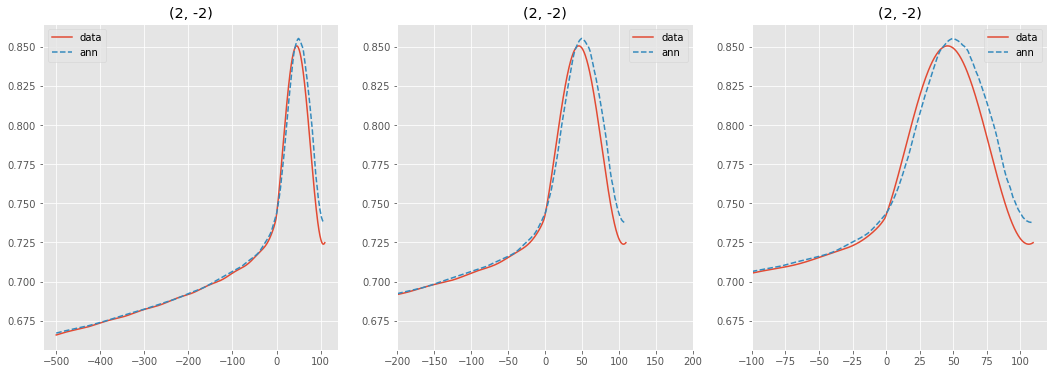

In [335]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(times, np.abs(wr_data.beta), label='data' )
plt.plot(times, np.abs(wr_ann.beta), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
plt.title(key)
plt.legend()

plt.subplot(1,3,2)
plt.plot(times, np.abs(wr_data.beta), label='data' )
plt.plot(times, np.abs(wr_ann.beta), label='ann',ls='--')
plt.xlim(-200, 200)
plt.title(key)
plt.legend()

plt.subplot(1,3,3)
plt.plot(times, np.abs(wr_data.beta), label='data' )
plt.plot(times, np.abs(wr_ann.beta), label='ann',ls='--')
plt.xlim(-100, 120)
plt.title(key)
plt.legend()

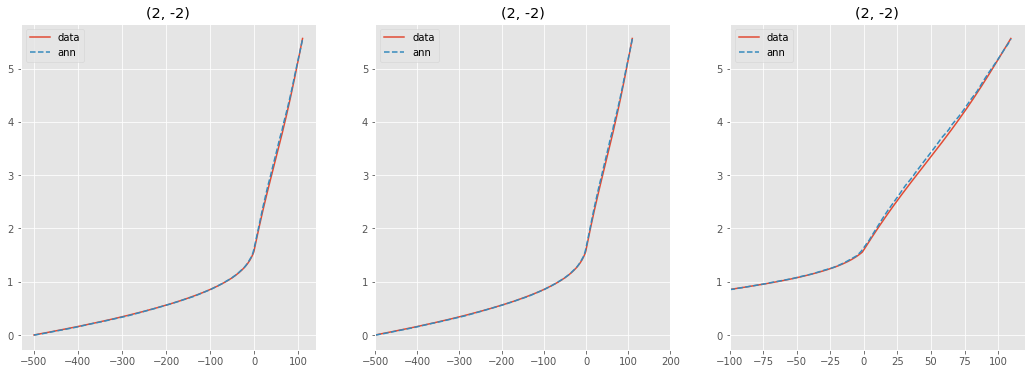

In [336]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(times, np.abs(wr_data.gamma), label='data' )
plt.plot(times, np.abs(wr_ann.gamma), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
plt.title(key)
plt.legend()

plt.subplot(1,3,2)
plt.plot(times, np.abs(wr_data.gamma), label='data' )
plt.plot(times, np.abs(wr_ann.gamma), label='ann',ls='--')
plt.xlim(-500, 200)
plt.title(key)
plt.legend()

plt.subplot(1,3,3)
plt.plot(times, np.abs(wr_data.gamma), label='data' )
plt.plot(times, np.abs(wr_ann.gamma), label='ann',ls='--')
plt.xlim(-100, 120)
plt.title(key)
plt.legend()

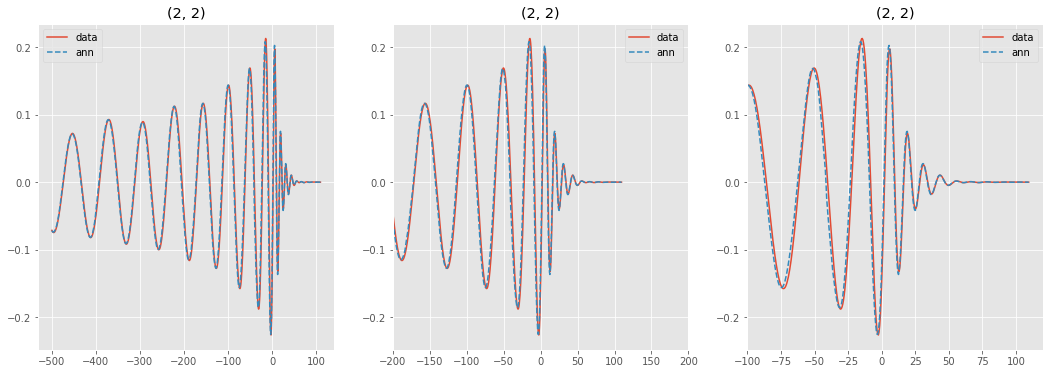

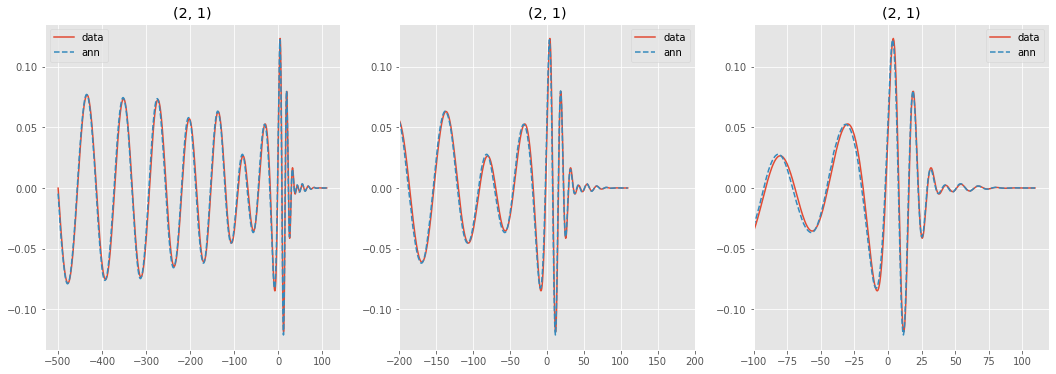

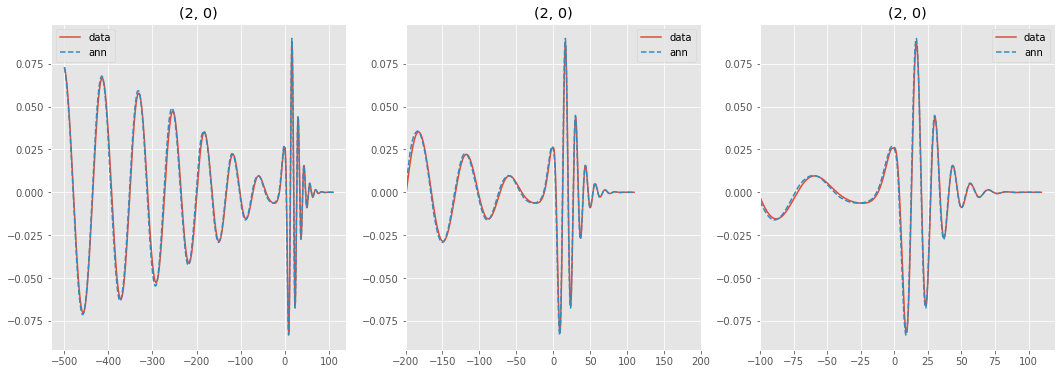

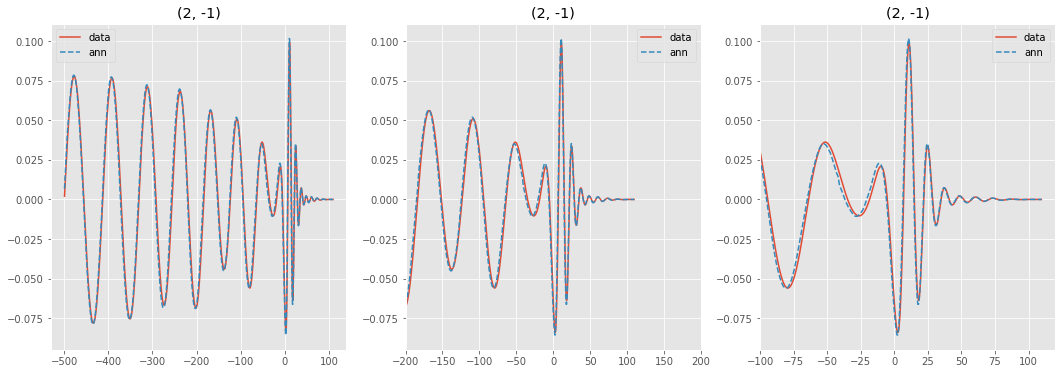

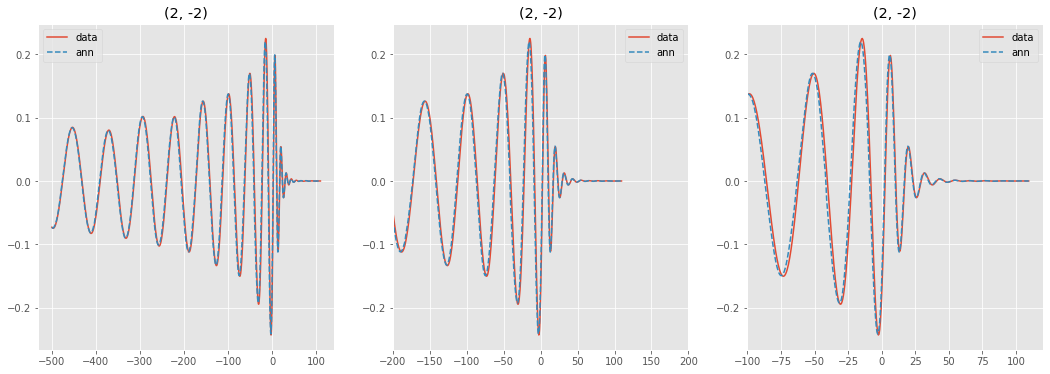

In [337]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.real(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.real(wr_ann.hlms[key]), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.real(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.real(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.real(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.real(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()

In [338]:
wr_data.from_inertial_frame_to_coprecessing_frame()
wr_ann.from_inertial_frame_to_coprecessing_frame()

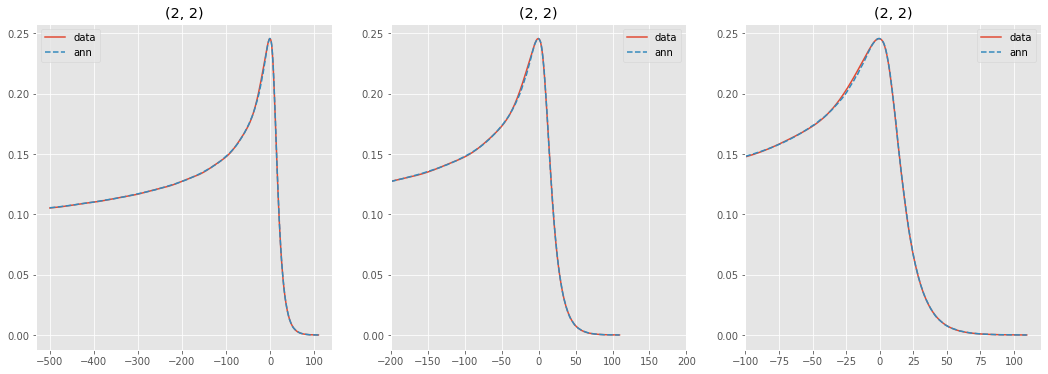

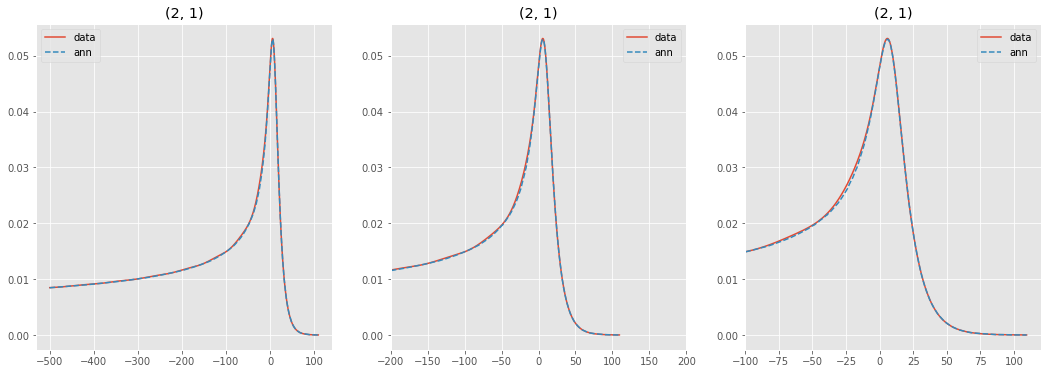

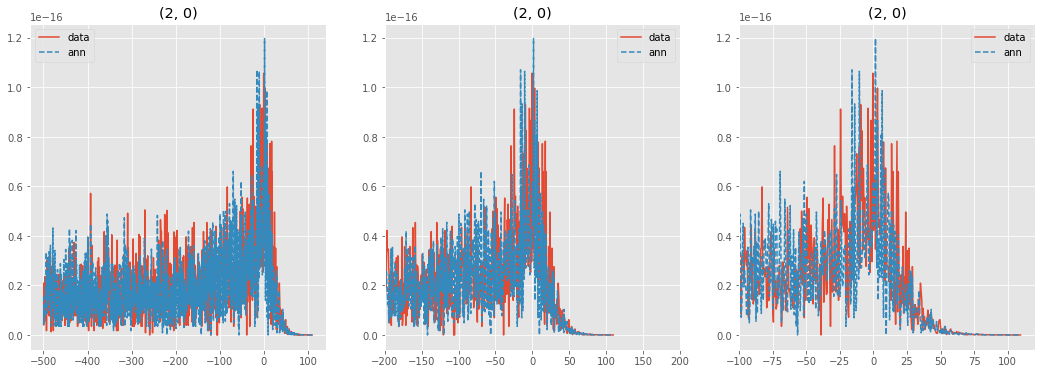

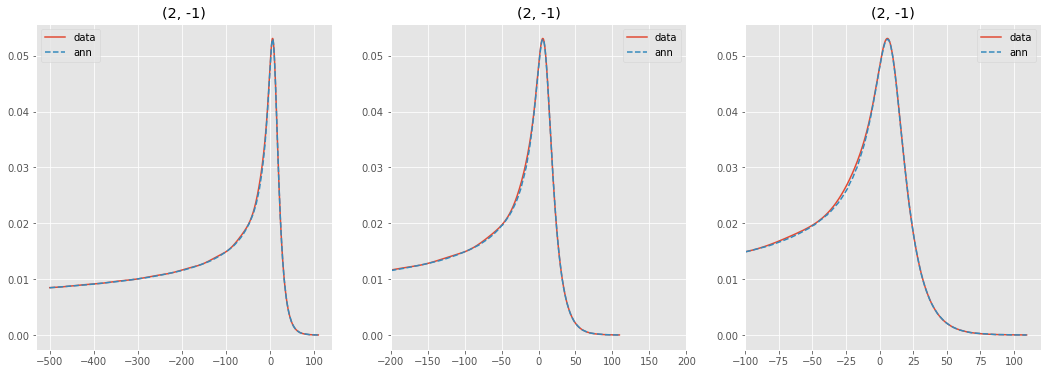

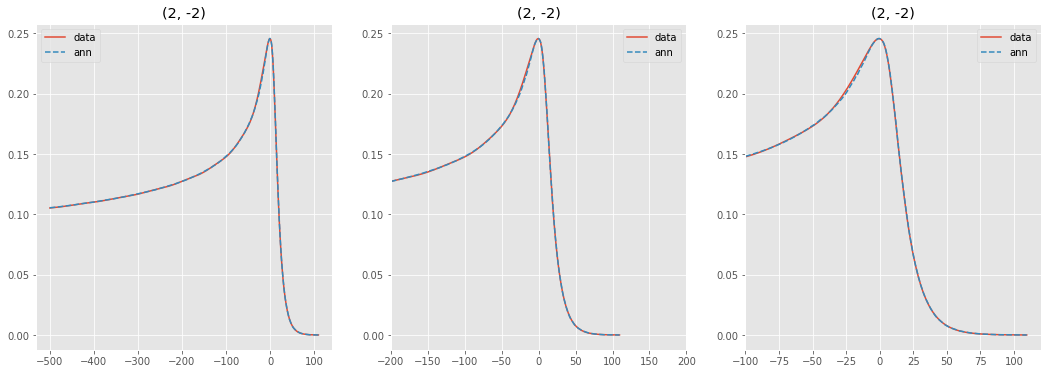

In [339]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.abs(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.abs(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()

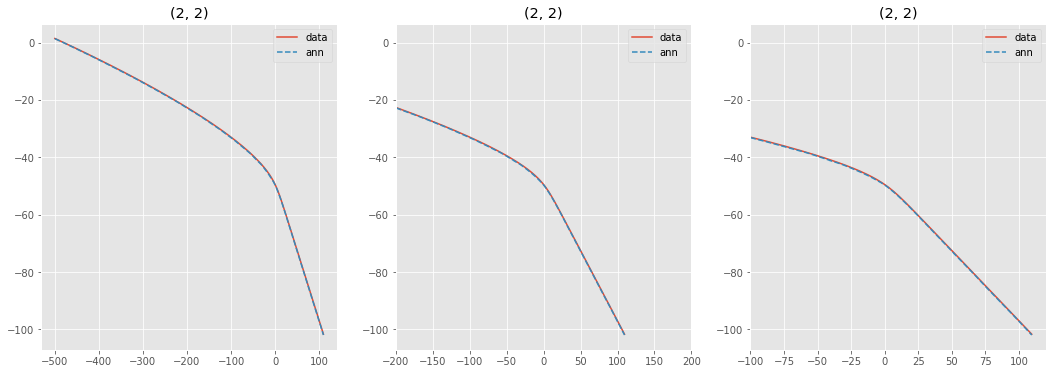

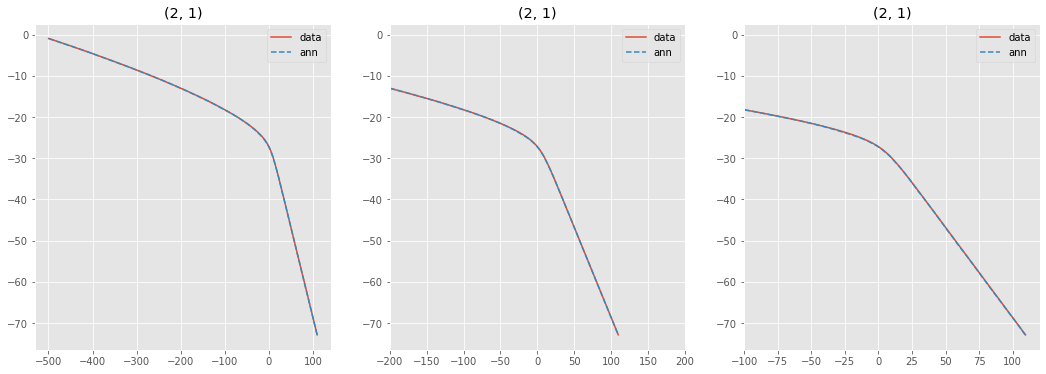

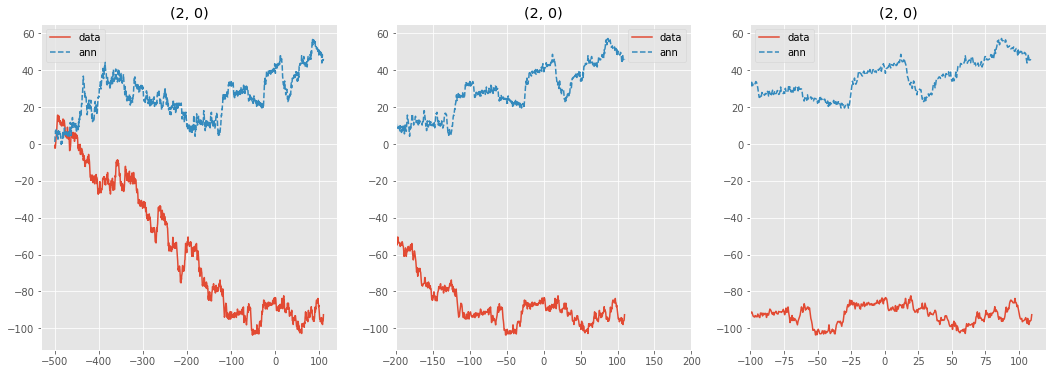

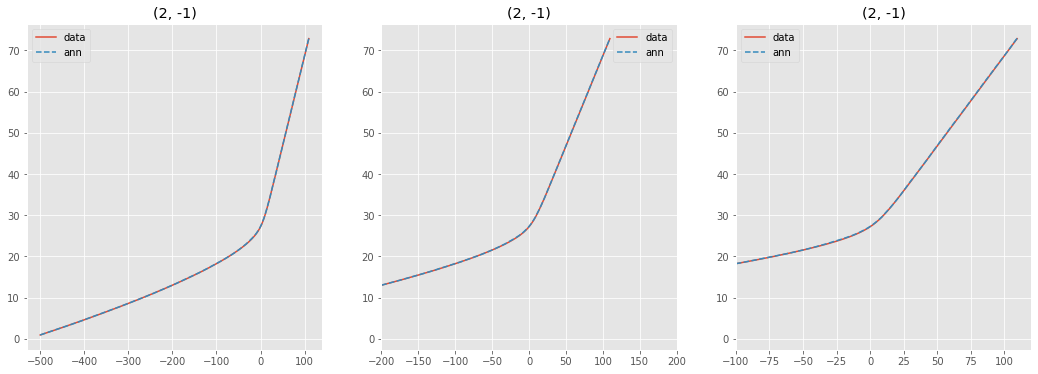

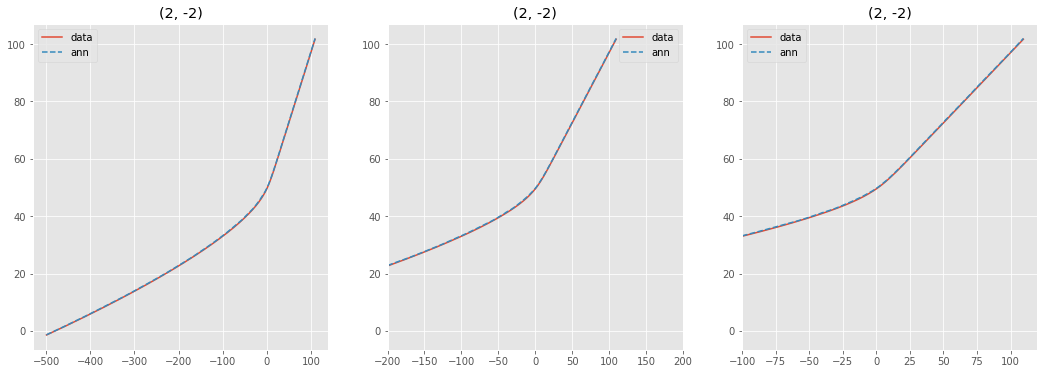

In [340]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.unwrap(np.angle(wr_data.hlms[key])), label='data' )
    plt.plot(times, np.unwrap(np.angle(wr_ann.hlms[key])), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.unwrap(np.angle(wr_data.hlms[key])), label='data' )
    plt.plot(times, np.unwrap(np.angle(wr_ann.hlms[key])), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.unwrap(np.angle(wr_data.hlms[key])), label='data' )
    plt.plot(times, np.unwrap(np.angle(wr_ann.hlms[key])), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()

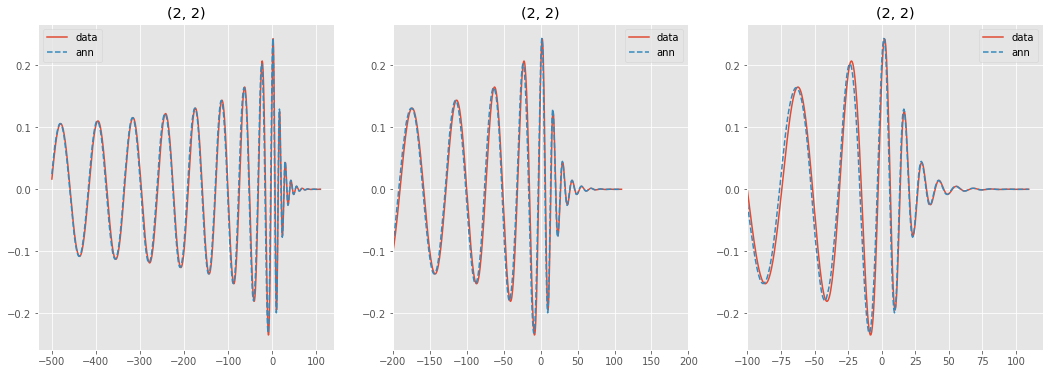

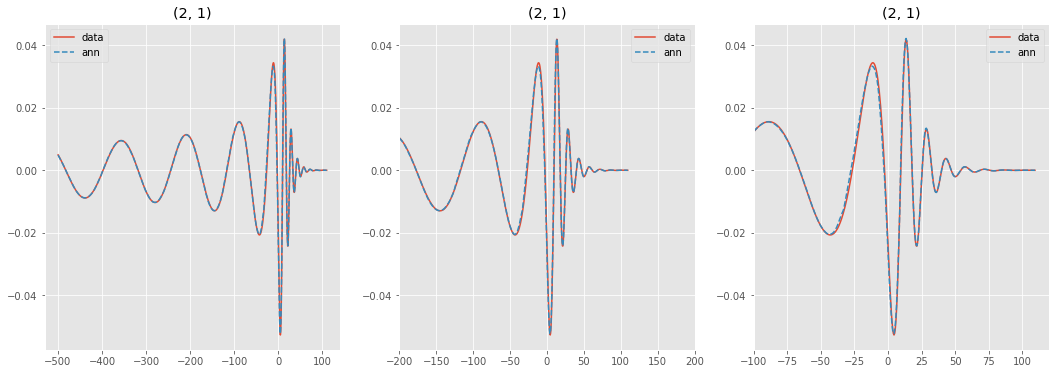

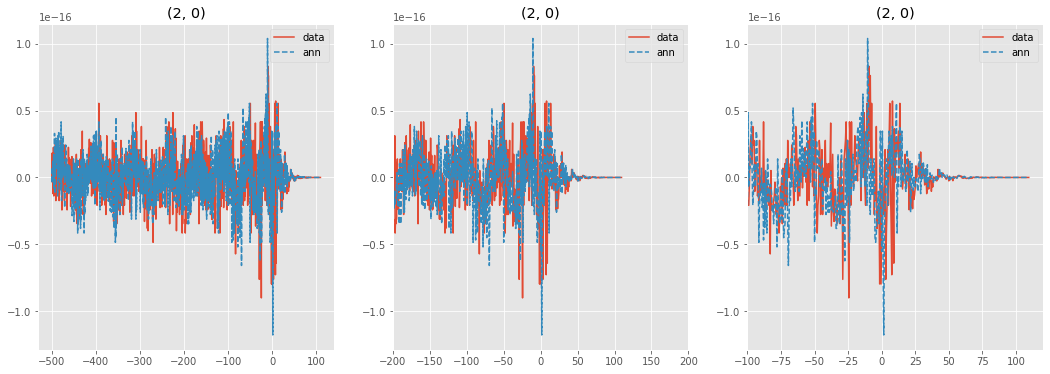

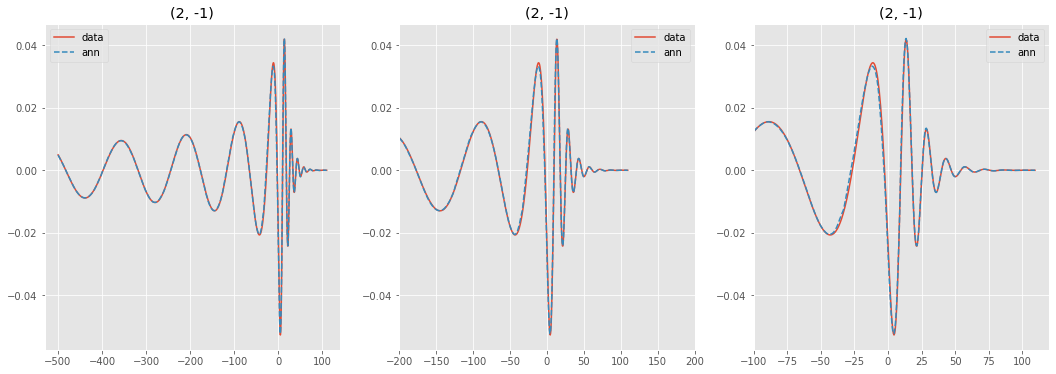

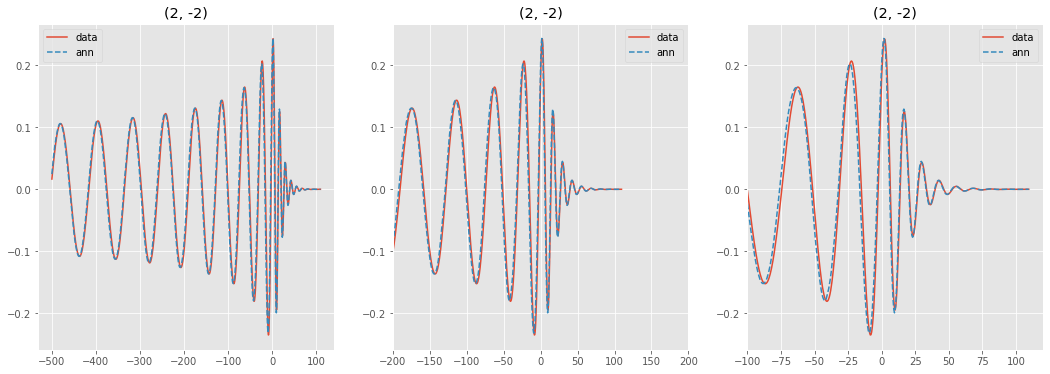

In [341]:
for key in wr_data.hlms.keys():
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.plot(times, np.real(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.real(wr_ann.hlms[key]), label='ann', ls='--')
#     plt.xlim(-0.5,0.1)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(times, np.real(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.real(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-200, 200)
    plt.title(key)
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(times, np.real(wr_data.hlms[key]), label='data' )
    plt.plot(times, np.real(wr_ann.hlms[key]), label='ann',ls='--')
    plt.xlim(-100, 120)
    plt.title(key)
    plt.legend()